## Loading packages

In [1]:
from IPython.display import display
import os
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=float32,force_device=True' #this ensures your program will run on a GPU. 
import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


Defining where you want the results of the analysis to be

In [2]:
results_folder = "/media/gambino/students_workdir/nynke/results/scRNA_combined"

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

## Loading Visium and reference scRNAseq data

### Visium

Load visium with scanpy, specify which out folder it can find all the visium data. 
Need to define the path in the sc.read_visium, it complains when you give the path as a separate variable. These two sections below are the two best tissue slices according to Nathalie

* Section 4: "/media/gambino/students_workdir/ibp/visium_data/Slide1/1579_deep/outs"
* Section 7: "/media/gambino/students_workdir/ibp/visium_data/Slide2-3/1345_start-EP/outs"

In [8]:
adata_vis = sc.read_visium("/media/gambino/students_workdir/ibp/visium_data/Slide2-3/1345_start-EP/outs")
#adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0] #add sample_id to metadata. Not necessary when only using 1 sample.

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Rename genes to ENSEMBL ID: so you can match scRNAseq with visium and can ignore the non-unique name warning in the previous cell

In [9]:
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

You can still plot gene expression by name using standard scanpy functions as follows:

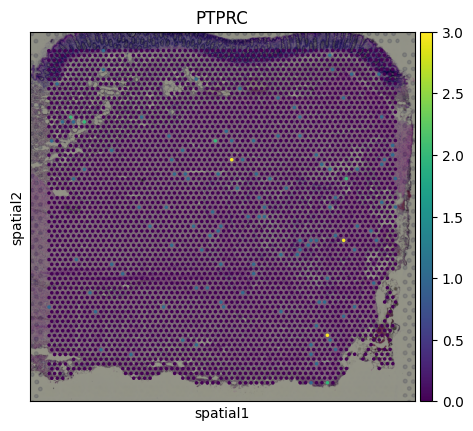

In [10]:
sc.pl.spatial(adata_vis, color='PTPRC', gene_symbols='SYMBOL')

Filter out the mitochondria-encoded genes (gene names starting with prefix mt- or MT-), as they are not relevant for cell deconvolution

In [11]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

### scRNAseq

**IMPORTANT** Ensure that the scRNAseq is **non-transformed** and **non-normalized**

paths to different scRNAdatasets:
* Original human gut cell atlas: 
    * '/media/gambino/students_workdir/ibp/scRNA_data/Full_obj_raw_counts_nosoupx_v2.h5ad'
    * With `Integrated_05` as the fine-grained subcelltype annotation
    * With `category` as the higher level cell type annotation.
* Altered labels human gut cell atlas
    * '/media/gambino/students_workdir/ibp/scRNA_data/raw_exploded_categories.h5ad'
    * With `category` containing the higher level cell type annotation, but where neuronal and myeloid cells have been exploded into:
        * Neuronal: Glia, Neuroblast,  Branch neurons (neurons from all lineages branches combined)
        * Myeloid: Dendritic, LYVE1+ Macrophage, Monocytes, Mast cell, MMP9+ Inflammatory macrophage, MPO+ mono-neutrophil
    * `Integrated_05` is still available in this dataset. 
* combined scRNA datasets: altered labels human gut cell atlas + own scRNAseq dataset.
    * '/media/gambino/students_workdir/ibp/combined_homemadeimmuneannotated_humangutatlas.h5'
    * With `combined_labels` as the annotated class

In [7]:
# Read data
path_to_scRNAseq = '/media/gambino/students_workdir/ibp/combined_homemadeimmuneannotated_humangutatlas.h5'
adata_ref = sc.read_h5ad(path_to_scRNAseq)

Create labels for the two datasets in the combined dataframe. This is based on whether it has values or NaN's in the column `Integrated_05`, which contain the fine-grained celltype annotations in the gut cell atlas, and are NaN's in the in-house dataset.  

In [8]:
adata_ref.obs['Study'] = np.where(adata_ref.obs['Integrated_05'].isnull(), 'in-house dataset', 'gut cell atlas')

The combined _labels now include a non-descriptive label called 'Neuronal'. When comparing these cells to their annotation in the gut cell atlas, we see that these are all the developing glia cells that were previously merged together with the 'Adult glia' marker, whereas now they are separate as we only used the 'adult glia' marker when combining the two datasets.

In [9]:
adata_ref[adata_ref.obs['combined_labels'] == 'Neuronal'].obs['Integrated_05'].unique()

['Differentiating glia', 'Glia 3 (BCAN+)', 'Glia 2 (ELN+)', 'Glia 1 (DHH+)', 'cycling neuroblast', 'cycling ENCC/glia', 'ENCC/glia Progenitor']
Categories (7, object): ['Differentiating glia', 'ENCC/glia Progenitor', 'Glia 1 (DHH+)', 'Glia 2 (ELN+)', 'Glia 3 (BCAN+)', 'cycling ENCC/glia', 'cycling neuroblast']

Therefore, we will now change the name of the 'Neuronal' to 'Developing Glia' to give it a more descriptive name.
We first create a new category, and then change it.

In [10]:
# Check if update correctly by counting the number of instances with 'Neuronal' as a label
neuronal_count = adata_ref.obs['combined_labels'].value_counts().get('Neuronal', 0)
print(f'Number of instances with "Neuronal" beforehand: {neuronal_count}')

new_category = 'Developing Glia'

# Add the new category if it doesn't exist
if new_category not in adata_ref.obs['combined_labels'].cat.categories:
    adata_ref.obs['combined_labels'] = adata_ref.obs['combined_labels'].cat.add_categories(new_category)

# Update the values based on the condition
adata_ref.obs.loc[adata_ref.obs['combined_labels'] == 'Neuronal', 'combined_labels'] = new_category

# Check if update correctly by counting the number of instances with 'Neuronal' as a label
neuronal_count = adata_ref.obs['combined_labels'].value_counts().get('Neuronal', 0)
print(f'Number of instances with "Neuronal" afterwards: {neuronal_count}')

Number of instances with "Neuronal" beforehand: 10391
Number of instances with "Neuronal" afterwards: 0


The combined anndata object contains both normalized data and the raw counts. Cell2location needs the raw counts, so therefore we will select that as our X.

In [11]:
adata_ref.X=adata_ref.layers["raw_counts"]

## Generate Reference Cell Type Matrix

### Preprocessing before estimating reference cell type signature

Before we estimate the reference cell type signature we recommend to perform very permissive genes selection. We prefer this to standard highly-variable-gene selection because our procedure keeps markers of rare genes while removing most of the uninformative genes.

Default selection settings: 
* Selecting genes detected at mRNA count >0 in >3% of cells
* Selecting genes detected at mRNA count >0 in a few cells (3% > cell count > 0.1%) but with a mean expression across non-zero cells >1.122018

The default parameters `cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12` are a good starting point, however, you can increase the cut-off to exclude more genes. To preserve marker genes of rare cell types we recommend low `cell_count_cutoff=5`, however, `cell_percentage_cutoff2` and `nonz_mean_cutoff` can be increased to select between 8k-16k genes.

In this 2D histogram, orange rectangle highlights genes excluded based on the combination of number of cells expressing that gene (Y-axis) and average RNA count for cells where the gene was detected (X-axis).

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


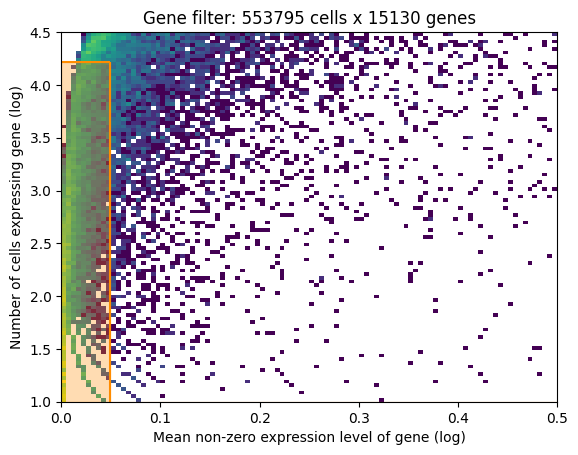

In [12]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

### Estimation of reference cell type signature (NB regression)

The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative binomial regression model.

In [13]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='batch', # key for the different samples in the dataset.
                        # cell type, covariate used for constructing signatures. It is called `Integrated_05` in the gut_atlas & `combined_labels` in the integrated dataset
                        labels_key='combined_labels',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect). `Study` flags whether the sample comes from the gut cell atlas or the in-house data.
                        categorical_covariate_keys=['Study']
                       )

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2/lib/python3.9/abc.py:98: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [14]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'batch',
│   'labels_key': 'combined_labels',
│   'categorical_covariate_keys': ['Study'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │  186   │
│         n_cells          │ 553795 │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   25   │
│          n_vars          │ 15130  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                        batch State Registry                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    4918STDY7273964     │          0          │
│                    │    4918STDY7273965     │          1          │
│                    │    4918STDY7274839     │          2          │
│                    │    4918STDY7317585     │          3          │
│                    │    4918STDY7317586     │          4          │
│                    │    4918STDY7317587     │          5          │
│                    │    4918STDY7321513     │          6          │
│                    │    4918STDY7321514     │          7          │
│                    │    4918STDY7321515     │          8          │
│                    │    4918STDY7333456     │          9          │
│                    │    4918STDY7389431     │         10          │
│                    │    4918STDY7421297     │         11          │
│                    │    4918STDY7421298     │         12          │
│                    │    4918STDY7421299     │         13          │
│                    │    4918STDY7426904     │         14          │
│                    │    4918STDY7426905     │         15          │
│                    │    4918STDY7426906     │         16          │
│                    │    4918STDY7426907     │         17          │
│                    │    4918STDY7426908     │         18          │
│                    │    4918STDY7426909     │         19          │
│                    │    4918STDY7447825     │         20          │
│                    │    4918STDY7693757     │         21          │
│                    │    4918STDY7693758     │         22          │
│                    │    4918STDY7693759     │         23          │
│                    │    4918STDY7693760     │         24          │
│                    │    4918STDY7693761     │         25          │
│                    │    4918STDY7693762     │         26          │
│                    │    4918STDY7693763     │         27          │
│                    │    4918STDY7702679     │         28          │
│                    │    4918STDY7702680     │         29          │
│                    │    4918STDY7714149     │         30          │
│                    │    4918STDY7714150     │         31          │
│                    │    4918STDY7717783     │         32          │
│                    │    4918STDY7717784     │         33          │
│                    │    4918STDY7717785     │         34          │
│                    │    4918STDY7717787     │         35          │
│                    │    4918STDY7717788     │         36          │
│                    │    4918STDY7717789     │         37          │
│                    │    4918STDY7718972     │         38          │
│                    │    4918STDY7718973     │         39          │
│                    │    4918STDY7718974     │         40          │
│                    │    4918STDY7718975     │         41          │
│                    │    4918STDY7718976     │         42          │
│                    │    4918STDY7718977     │         43          │
│                    │    4918STDY7844898     │         44          │
│                    │    4918STDY7844899     │         45          │
│                    │    4918STDY7901096     │         46          │
│                    │    4918STDY7923744     │         47          │
│                    │    4918STDY7933270     │         48          │
│                    │    4918STDY7962470     │         49          │
│                    │    4918STDY7982702     │         50          │
│                    │    4918STDY7982703     │         51          │
│                    │     FCA_gut8015057     │         52          │
│         

                                labels State Registry                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃          Categories           ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['combined_labels'] │          Adult Glia           │          0          │
│                              │            B Cells            │          1          │
│                              │            B cells            │          2          │
│                              │        Dendritic cells        │          3          │
│                              │          Endothelial          │          4          │
│                              │          Epithelial           │          5          │
│                              │             ILCs              │          6          │
│                              │     Immune Cycling cells      │          7          │
│                              │ MMP9+ Inflammatory macrophage │          8          │
│                              │     MPO+ mono-neutrophil      │          9          │
│                              │     Macrophages CCL3 CCL4     │         10          │
│                              │     Macrophages Classical     │         11          │
│                              │       Macrophages LYVE1       │         12          │
│                              │  Macrophages Metallothionein  │         13          │
│                              │    Macrophages Subcelltype    │         14          │
│                              │          Mast cells           │         15          │
│                              │          Mesenchymal          │         16          │
│                              │           Monocytes           │         17          │
│                              │          Neuroblast           │         18          │
│                              │         Plasma cells          │         19          │
│                              │        Red blood cells        │         20          │
│                              │            T cells            │         21          │
│                              │        branch neurons         │         22          │
│                              │         megakaryocyte         │         23          │
│                              │        Developing Glia        │         24          │
└──────────────────────────────┴───────────────────────────────┴─────────────────────┘

             extra_categorical_covs State Registry             
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Study'] │  gut cell atlas  │          0          │
│                    │ in-house dataset │          1          │
│                    │                  │                     │
└────────────────────┴──────────────────┴─────────────────────┘

Off note: the WDTAtest cells come from the gut cell atlas rather than our in-house dataset, so we leave them in.

### Training the model to estimate cell reference types.

Note that to achieve convergence on your data you may need to increase `max_epochs=250`, check by plotting ELBO loss history during training (remove first 20 epochs from the plot). If the plot is still decreasing by the end, increase `max_epochs`. Within our analysis, we increased the standard `max_epochs=250` to 450 to ensure we achieved convergence. 

Also note that here we are using `batch_size=2500` which is much larger than scvi-tools default and perform training on all cells in the data (`train_size=1`) - both parameters are defaults.

**Debugging note** Did you get an error along the lines of:

ValueError: Expected value argument (Tensor of shape (2500, 14905)) to be within the support (IntegerGreaterThan(lower_bound=0)) of the distribution GammaPoisson(), but found invalid values:
...
         alpha_g_inverse dist            |  1 14905
                        value            |  1 14905
                     log_prob            |
             data_target dist 2500 14905 |
                        value 2500 14905 |


You probably tried to run normalized and/or transformed scRNAseq data. Try again with the raw dataset.
                        

In [18]:
mod.train(max_epochs=450, use_gpu=True)

RegressionBackgroundDetectionTech model with the following params: 
n_factors: 25 
n_batch: 186 
Training status: Trained
Model's adata is minified?: False

RegressionBackgroundDetectionTech model with the following params: 
n_factors: 25 
n_batch: 186 
Training status: Trained
Model's adata is minified?: False

KeyboardInterrupt: 

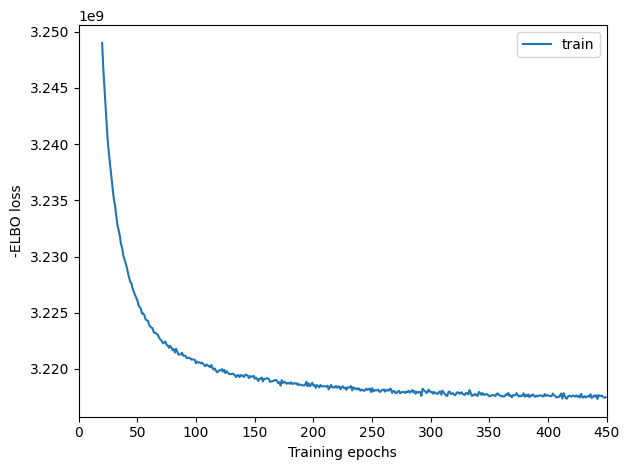

In [16]:
# ELBO plot of the history of training the model, with first 20 epochs removed
mod.plot_history(20)

#the plot that you see here now is actually from the total trained model iso the cell reference model. Need to load data again to see if the training actually converged

In [17]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:13<00:00, 75.32it/s]


'/media/gambino/students_workdir/nynke/results/results/scRNA_combined/reference_signatures/sc.h5ad'

### Examine QC plots

Here we simply compute the quantiles based on the samples, as we need the posterior mean and steandard deviation to make the QC plot next cell. 

If you have a large dataset, you can compute the 5%, 50% and 95% quantiles of the posterior distribution directly rather than using 1000 samples from the distribution (or any other quantiles). This speeds up application on large datasets and requires less memory - however, posterior mean and standard deviation cannot be computed this way.

In [19]:
adata_ref = mod.export_posterior(
    adata_ref, use_quantiles=False,
    # choose quantiles
    #add_to_varm=["means", "stds", "q05", "q95"]
    #add_to_obsm=["q05","q50", "q95", "q0001"],
    sample_kwargs={'batch_size': 2500, 'use_gpu': True}
)

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:11<00:00, 85.59it/s]



* Reconstruction accuracy to assess if there are any issues with inference. This 2D histogram plot should have most observations along a noisy diagonal.
* The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.


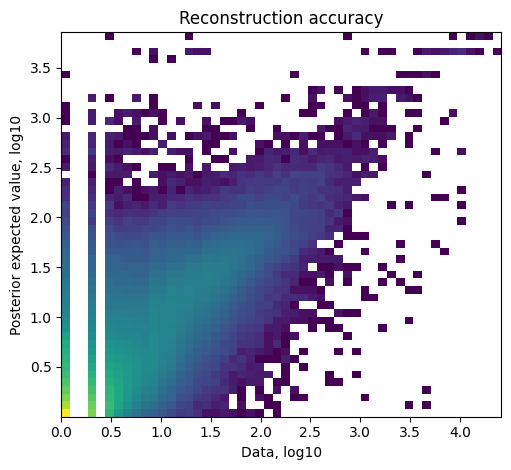

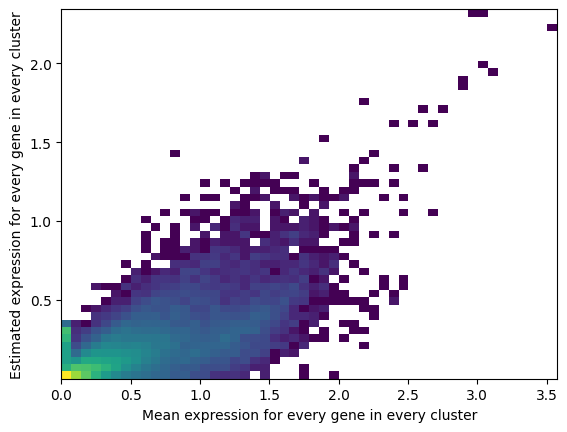

In [20]:
mod.plot_QC()

The model and output h5ad can be loaded later like this:

In [6]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File /media/gambino/students_workdir/nynke/results/results/scRNA_combined/reference_signatures/model.pt   
         already downloaded                                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2/lib/python3.9/abc.py:98: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 1/36:   3%|▎         | 1/36 [00:00<00:06,  5.09it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/36:   3%|▎         | 1/36 [00:00<00:07,  4.99it/s, v_num=1]


Extracting reference cell types signatures as a pd.DataFrame.

All parameters of the a Negative Binomial regression model are exported into reference anndata object, however for spatial mapping we just need the estimated expression of every gene in every cell type. Here we extract that from standard output:


In [12]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

Adult Glia   B Cells   B cells  Dendritic cells  Endothelial
gene_ids                                                                     
ENSG00000000003    0.072538  0.000085  0.000912         0.001148     0.147410
ENSG00000000005    0.001960  0.000028  0.000032         0.000012     0.001267
ENSG00000000419    0.024731  0.029853  0.030494         0.057681     0.113491
ENSG00000000457    0.006276  0.014833  0.009194         0.011696     0.022821
ENSG00000000938    0.001402  0.011096  0.016314         0.380738     0.034532

## Cell2location: spatial mapping

Find shared genes and prepare anndata. Subset both anndata and reference signatures:

In [13]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis)
# If analysing multiple visium slices in one experiment, use the argument below instead
# cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

### Choose your hyperparameters

For detailed guidance on choosing your hyperparameters and their impact, [click here](https://github.com/BayraktarLab/cell2location/blob/master/docs/images/Note_on_selecting_hyperparameters.pdf). For a short summary, continue reading:


*Choosing hyperparameter `N_cells_per_location`*
* Estimate this hyperparameter based on the paired histology images, or if not avaiable you can use images from the same tissue of unrelated experiments. If both are not avaiable, you can give an estimate based on the spatial transcriptomics technique (i.e. Visium has on average 5 cells per spot) 
* If you do estimate based on an image, you pick 10-20 random locations and manually count the nuclei to compute average cell abundance. 
    * We opted not to loop over different priors, because we have no clear method of comparing the different posterior models. Loading the image in Loupe Browser (via LoupeR) as suggested by the paper was unsuccesful. 
    * Ultimately we compared `tissue_hires_image.png` with `detected_tissue_image.jpg` at the same scale. We measured the diameter of a spot, and then used that to estimate cell-count per spot on the hires_image.  
* Default is a single tissue-level estimate, but can also use per-location number of cells if there are large differences between different regions on your tissue slice. 

*Choosing hyperparameter `detection_alpha`*
* Determines the amount of regularization or per-location normalisation in preprocessing. You should choose based on the amount of technical variability in RNA detection sensitivity within your slide/batch. 
* high technical variability in RNA detection sensitivity is in your sample if your observed spatial distribution of total RNA count per location doesn't match the expected cell numbers based on histological examination.
* High technical effects? Choose `detection_alpha=20` (default, as this seems common for Visium experiments on human tissues)
* Low technical effects? Choose `detection_alpha=200`. High regularization improves consistency between total estimated cell abundance per location and the nuclei count quantified in `N_cells_per_location`
* Try both settings on your data, i.e. `detection_alpha=20` and `detection_alpha=200`





In [14]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=12,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()



Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 4305  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 15117 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

### Train cell2location

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:281: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps i

Epoch 30000/30000: 100%|██████████| 30000/30000 [51:15<00:00,  9.83it/s, v_num=1, elbo_train=1.74e+7]

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [51:15<00:00,  9.76it/s, v_num=1, elbo_train=1.74e+7]


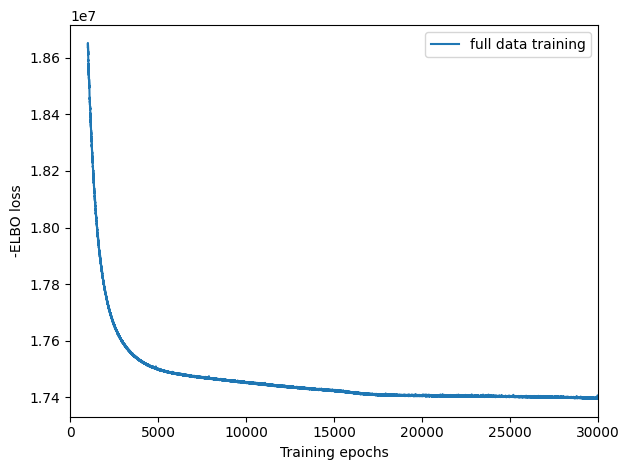

In [15]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

Exporting estimated posterior distributions of cell abundance and saving results:

In [16]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)


# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:17<00:00, 55.52it/s]


'/media/gambino/students_workdir/nynke/results/results/scRNA_combined/cell2location_map/sp1345_12.h5ad'

The model and output h5ad can be loaded later like this:

In [3]:
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

INFO     File /media/gambino/students_workdir/nynke/results/results/scRNA_combined/cell2location_map/model.pt      
         already downloaded                                                                                        


/media/gambino/students_workdir/nynke/miniconda3/envs/cell2/lib/python3.9/abc.py:98: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce 

Epoch 1/30000:   0%|          | 1/30000 [00:00<3:41:11,  2.26it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|          | 1/30000 [00:00<3:45:46,  2.21it/s, v_num=1]


Assessing mapping quality. Examine reconstruction accuracy to assess if there are any issues with mapping. The plot should be roughly diagonal, strong deviations will signal problems that need to be investigated.

Sampling global variables, sample: 100%|██████████| 999/999 [00:09<00:00, 101.37it/s]


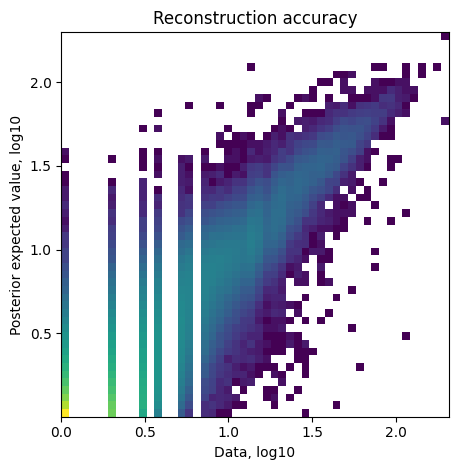

In [17]:
mod.export_posterior(adata_vis)
mod.plot_QC()

## Visualising cell abundance in spatial coordinates

Note: Cell2location recommends using 5% quantile of the posterior distribution, representing the value of cell abundance that the model has high confidence in (aka ‘at least this amount is present’).

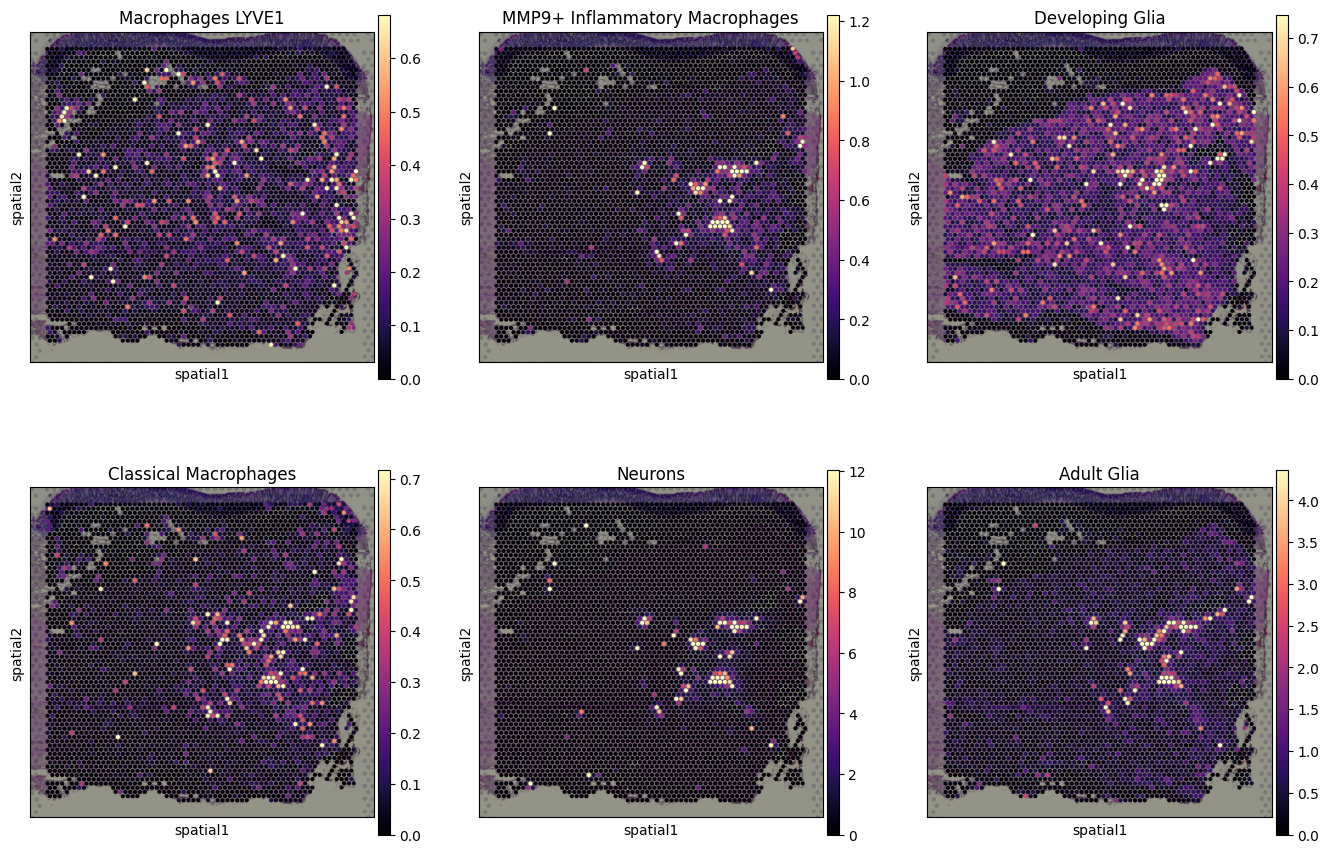

In [4]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

slide = adata_vis
# If you have multiple batches, instead use the commands below to retrieve slide of interest.
# from cell2location.utils import select_slide
# slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')


# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['Macrophages LYVE1','MMP9+ Inflammatory macrophage','Developing Glia','Macrophages Classical','branch neurons','Adult Glia'],
                  ncols=3, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2',
                  title=['Macrophages LYVE1','MMP9+ Inflammatory Macrophages','Developing Glia','Classical Macrophages','Neurons','Adult Glia'],
                 )

# Interesting cell names to plot for gut cell atlas:    
# 'LYVE1+ Macrophage', 'MMP9+ Inflammatory macrophage', 'Macrophages', 'Monocytes', 'Branch A2 (IPAN/IN)', 'Branch A3 (IPAN/IN)', 'Branch A4 (IN)', 'Branch B3 (IPAN)', 'Glia 1 (DHH+)', 'Glia 2 (ELN+)', 'Glia 3 (BCAN+)', 'Adult Glia', 'CX3CR1+ CD8 Tmem', 'cycling ENCC/glia', 'SMC (PART1/CAPN3+)', 'ICC'

# all cell names for the gut cell atlas with combined celltypes:
# 'MMP9+ Inflammatory macrophage','LYVE1+ Macrophage','Macrophages','Dendritic','Glia','Branch Neurons','Monocytes','Endothelial','Mast cell','B cells','T cells','Epithelial','Mesenchymal','Plasma cells','Neuroblast','MPO+ mono-neutrophil','Red blood cells','Megakaryocyte'

# Interesting cell names to plot for the integrated dataset:     
# 'Macrophages LYVE1','MMP9+ Inflammatory macrophage','Macrophages Metallothionein','Macrophages Classical','branch neurons','Adult Glia','Macrophages CCL3 CCL4','Macrophages Subcelltype','Developing Glia'

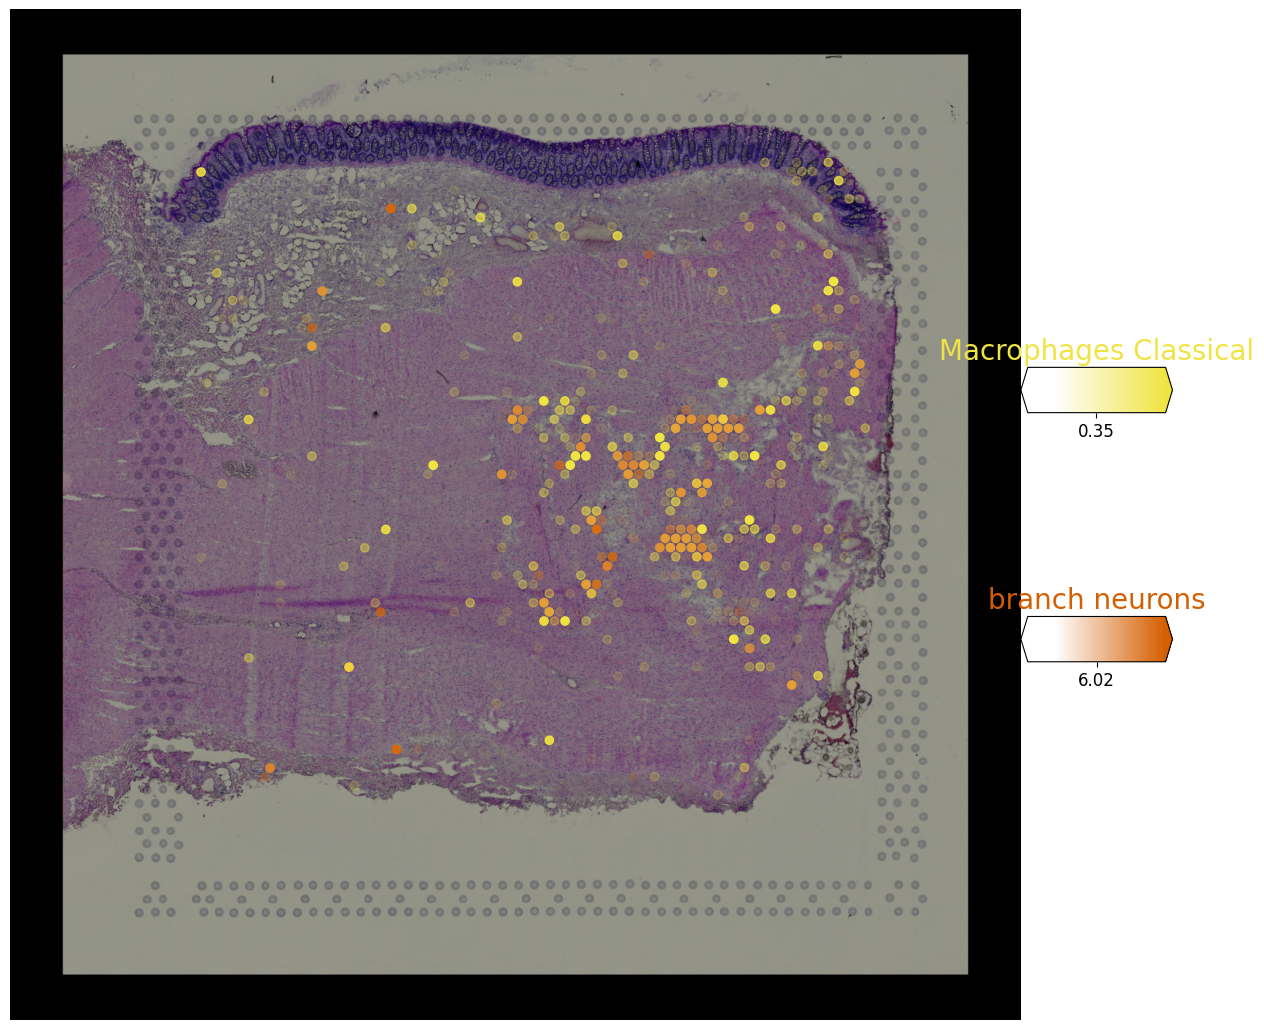

In [20]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['Macrophages Classical', 'branch neurons']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

#slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')
slide = adata_vis
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )